# Conversion of damages in NatCatSERVICE and EM-DAT to constant 2015 Int$PPP

Damages provided in NatCatSERVICE are given in current US$\$ $ and constant 2016 US$\$$. In EM-DAT damages are provided in current US$\$$ and adjusted to the inflation level of the years in which the database was accessed (constant 2024 US$\$$). In order to match the unit of the GDP estimates from DOSE (constant Int$\$$PPP), we convert the damage estimates of both databases to constant Int%$PPP applying GDPuc tool introduced by Koch and Leimbach 2023. Numbers are first converted to the local currency unit (LCU) applying annual exchange rates, then deflated and converted from market exchange rates to PPP. Exchange rates, deflators and price levels are derived from the World Development Indicators (World Bank 2008). There is a number of years and countries where the conversion in complicated through missing data. For these countries alternative procedures are applied (Supplementary Notes).

Koch, J. and Leimbach, M.: SSP economic growth projections: Major changes of key drivers in integrated assessment modelling, Ecol. Econ., 206, 107751, https://doi.org/10.1016/j.ecolecon.2023.107751, 2023.

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import CubicSpline

In [6]:
path_cluster = "/home/insauer/mnt/primap/USERS/annikag/drought/isimip/data"

## 1. Conversion of NatCatSERVICE

NatcatSERVICE Data is given in current USD and current exchange rates 'damage_currentUSD',
and in constant 2016 USD at current exchange rates 'damage_constant2016USD'


In [7]:
damage_natcat = pd.read_csv(f"{path_cluster}/damages/natcat_dry_CPI_adjusted_annika_more_info.csv", index_col=0)
damage_natcat = damage_natcat.loc[damage_natcat.subtype == "dr:Drought"]
# delete events without country information (these are usually multi-country events,
#which are diaggregated additionally)
damage_natcat = damage_natcat.loc[~damage_natcat.iso3.isna()]
# rename columns to comprehensive units
damage_natcat=damage_natcat.rename(columns={'tot_loss': 'damage_currentUSD_MER',
                              'tot_loss_CPI': 'damage_constant2016USD_MER'})


In [8]:
damage_natcat.columns

Index(['year', 'begin', 'begin_yr', 'begin_mon', 'end', 'end_yr', 'end_mon',
       'event', 'type', 'subtype', 'iso3', 'country', 'country_read',
       'Continent', 'damage_currentUSD_MER', 'ins_loss', 'tot_loss_GDP',
       'tot_loss_GCP', 'damage_constant2016USD_MER', 'Fatalities', 'Longitude',
       'Latitude', 'Reg_name', 'ID', 'Reg_ID', 'CPI_conv', 'GDP_conv',
       'unexact_conv', 'comment', 'MR Number', 'MR ID',
       'Association Type \n(Single + Main = Single-Country-Event; Country = Country data from Multi-Country-Event; Region =Multi-Country-Event; see sheet 'Read me') ',
       'Country Name', 'Affected Area', 'Affected Area (Detail)',
       'Description', 'Catastrophe Class', 'Geocoded Place'],
      dtype='object')

In [9]:
# rename SSD to SDN as before 2011 it did not exist
damage_natcat.loc[damage_natcat['iso3']=='SSD', 'iso3']='SDN'


## 1.1 First option: Conversion from current US$\$$MER to constant 2015 Int$\$$PPP

The direct conversion from current US$\$$MER to constant Int$\$$PP is considered the first option, as it makes use of a sound three step procedure: 
1. conversion to LCU
2. deflation to the reference years 2015/2017
3. conversion to PPP

This procedure has high data requirements and is therefore not applicable for the entire dataset.

In [10]:
# prepare a dataset for the GDPuc tool
natcat_current_USD_MER=damage_natcat[['iso3','year','damage_currentUSD_MER']]
natcat_current_USD_MER=natcat_current_USD_MER.rename(columns={'iso3': 'iso3c',
                                                              'damage_currentUSD_MER': 'value'})

In [11]:
natcat_current_USD_MER['value']=natcat_current_USD_MER['value']

In [12]:
natcat_current_USD_MER=natcat_current_USD_MER.reset_index()

In [13]:
natcat_current_USD_MER

,id,iso3c,year,value
0,0,ESP,1980,1500.0
1,9,SOM,1980,6.0
2,10,MOZ,1980,21.6
3,11,GMB,1980,10.5
4,12,MLI,1980,25.0
...,...,...,...,...
914,29778,FRA,2016,0.1
915,29936,CHN,2016,450.0
916,30097,CHN,2016,60.0
917,30236,LKA,2016,0.0


In [14]:
natcat_current_USD_MER.to_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/natcat_current_USD_MER_input_GDPuc.csv')

Here we apply the GDPuc tool, which is implemented in R: gdpuc_conv.ipynb

Note: We do not use any filling for missing values!

converted_2015 <- convertGDP(
    gdp = read_csv,
    unit_in = 'current US$\$$MER',
    unit_out = 'constant 2015 Int$\$$PPP',
    replace_NAs = NA
    )


In [15]:
# read the converted data from GDPuc
natcat_constant2015USD_PPP=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/natcat_constant_Int_2015PPP_output_GDPuc.csv')
natcat_constant2017USD_PPP=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/natcat_constant_Int_2017PPP_output_GDPuc.csv')

In [16]:
natcat_constant2017USD_PPP

,Unnamed: 0,X,id,iso3c,year,value
0,1,0,0,ESP,1980,5166.227764
1,2,1,9,SOM,1980,0.070457
2,3,2,10,MOZ,1980,NaN
3,4,3,11,GMB,1980,66.085882
4,5,4,12,MLI,1980,132.248623
...,...,...,...,...,...,...
914,915,914,29778,FRA,2016,0.117923
915,916,915,29936,CHN,2016,744.912423
916,917,916,30097,CHN,2016,99.321656
917,918,917,30236,LKA,2016,0.000000


In [17]:
# insert converted values from GDPuc in the NatCat-DataFrame
damage_natcat['damage_constant2015USD_PPP']=np.array(natcat_constant2015USD_PPP['value'])
damage_natcat['damage_constant2017USD_PPP']=np.array(natcat_constant2017USD_PPP['value'])
damage_natcat.loc[~damage_natcat['damage_constant2015USD_PPP'].isna(), 'conversion_source']='GDPuc_currentUSD_to_constantXPPP'

## 1.2 Second best option: Conversion from constant 2016 US$\$$MER to constant 2015 Int$\$$PPP

For these countries we apply a conversion from the constant US$\$$MER to constant 2015 Int$\$$PPP. This option has less data requirements, however, as the data given in NatCatSERVICE was most likely not converted with constant exchange rates we consider this method less exact and apply it only on the events that could not be converted by the first option.

In [18]:
# check missings
damage_natcat.loc[damage_natcat['damage_constant2015USD_PPP'].isna()].shape[0]

74

In [19]:
# print list of affected countries
set(damage_natcat.loc[damage_natcat['damage_constant2015USD_PPP'].isna(), 'iso3'])

{'AFG',
 'ASM',
 'CUB',
 'DJI',
 'ERI',
 'GIN',
 'HRV',
 'HUN',
 'KHM',
 'LBR',
 'LTU',
 'MDA',
 'MNE',
 'MOZ',
 'POL',
 'PRK',
 'ROU',
 'SOM',
 'SRB',
 'STP',
 'SYR',
 'TKL',
 'TWN',
 'TZA',
 'VEN',
 'VGB'}

In [20]:
natcat_constant_2016USD_MER=damage_natcat.loc[damage_natcat['damage_constant2015USD_PPP'].isna(), ['iso3','year', 'damage_constant2016USD_MER']]
natcat_constant_2016USD_MER=natcat_constant_2016USD_MER.rename(columns={'iso3': 'iso3c',
                                                              'damage_constant2016USD_MER': 'value'})
natcat_constant_2016USD_MER

,iso3c,year,value
id,,,
10,MOZ,1980,62.914456
168,DJI,1980,21.167744
420,CUB,1981,156.836257
455,GIN,1981,174.262508
457,MOZ,1981,174.262508
...,...,...,...
27487,PRK,2015,101.261513
27499,VGB,2015,0.151892
27634,CUB,2015,52.255920


In [21]:
natcat_constant_2016USD_MER.to_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/natcat_constant_2016USD_MER_input_GDPuc.csv')

Here we apply the GDPuc tool, which is implemented in R: gdpuc_conv.ipynb

Note: We use a missing filling option that uses a linear interpolation for missing years!

converted <- convertGDP(
    gdp = read_missings,
    unit_in = 'constant 2016 US$\$$MER',
    unit_out = 'constant 2015 Int$\$$PPP',
    replace_NAs = 'linear'
    )

In [22]:
natcat_constant_2015USD_PPP=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/natcat_missing_constant_Int_2015PPP_output_GDPuc.csv')
natcat_constant_2017USD_PPP=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/natcat_missing_constant_Int_2017PPP_output_GDPuc.csv')

In [23]:
natcat_constant_2015USD_PPP

,Unnamed: 0,id,iso3c,year,value
0,1,10,MOZ,1980,193.657903
1,2,168,DJI,1980,36.307005
2,3,420,CUB,1981,NaN
3,4,455,GIN,1981,467.278140
4,5,457,MOZ,1981,536.399962
...,...,...,...,...,...
69,70,27487,PRK,2015,NaN
70,71,27499,VGB,2015,NaN
71,72,27634,CUB,2015,NaN
72,73,27842,TWN,2015,NaN


In [24]:
# insert converted values to NatCat-DataFrame
damage_natcat.loc[damage_natcat['damage_constant2015USD_PPP'].isna(),
                                'damage_constant2015USD_PPP']=np.array(natcat_constant_2015USD_PPP['value'])
damage_natcat.loc[damage_natcat['damage_constant2017USD_PPP'].isna(),
                                'damage_constant2017USD_PPP']=np.array(natcat_constant_2017USD_PPP['value'])

In [25]:
damage_natcat.loc[~(damage_natcat['damage_constant2015USD_PPP'].isna()) &
                  (damage_natcat['conversion_source'].isna()), 'conversion_source'] ='GDPuc_constant2016MER_to_constantXPPP'

In [26]:
damage_natcat

,year,begin,begin_yr,begin_mon,end,end_yr,end_mon,event,type,subtype,...,Association Type \n(Single + Main = Single-Country-Event; Country = Country data from Multi-Country-Event; Region =Multi-Country-Event; see sheet 'Read me'),Country Name,Affected Area,Affected Area (Detail),Description,Catastrophe Class,Geocoded Place,damage_constant2015USD_PPP,damage_constant2017USD_PPP,conversion_source
id,,,,,,,,,,,,,,,,,,,,,
0,1980,01/01/1980 00:00,1980,1,31/08/1982 00:00,1982,8,Drought,D,dr:Drought,...,Country,Spain,"S, C",Murcia; Andalucia; Baleares,"Lack of rain, total abstinence of rain, dry sp...",4,ESP: Murcia,4824.336569,5166.227764,GDPuc_currentUSD_to_constantXPPP
9,1980,01/01/1980 00:00,1980,1,31/01/1980 00:00,1980,1,Drought,D,dr:Drought,...,Single,Somalia,"Entire country,",n.a,"Lack of rain. Cropland damaged, livestock affe...",3,SOM:,0.069383,0.070457,GDPuc_currentUSD_to_constantXPPP
10,1980,01/01/1980 00:00,1980,1,31/12/1980 00:00,1980,12,Drought,D,dr:Drought,...,Country,Mozambique,"S, C,",Manica; Sofala; Inhambane; Gaza,"Lack of rain, dry spell, hot temperatures. Riv...",3,MOZ: Manica,193.657903,187.422649,GDPuc_constant2016MER_to_constantXPPP
11,1980,01/01/1980 00:00,1980,1,31/12/1985 00:00,1985,12,Drought,D,dr:Drought,...,Country,Gambia,"Entire country,",n.a,"Lack of rain, dry spell. Cropland damaged/dest...",3,GMB:,66.349153,66.085882,GDPuc_currentUSD_to_constantXPPP
12,1980,01/01/1980 00:00,1980,1,31/12/1982 00:00,1982,12,Drought,D,dr:Drought,...,Country,Mali,"W,","Kayes, Timbuktu","Lack of rain, dry spell, hot temperatures. Cro...",3,MLI: Kayes,125.630406,132.248623,GDPuc_currentUSD_to_constantXPPP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29778,2016,01/07/2016 00:00,2016,7,17/08/2016 00:00,2016,8,Drought,D,dr:Drought,...,Single,France,"W, C, S,","Eure-et-Loir, Indre, Loire-Atlantique, Vendée,...","Dry conditions, lack of rain. Water restrictio...",0,"FRA: Loiré, Loiré",0.111133,0.117923,GDPuc_currentUSD_to_constantXPPP
29936,2016,01/08/2016 00:00,2016,8,05/09/2016 00:00,2016,9,Drought,D,dr:Drought,...,Single,China,"N,",Gansu,"Lack of rain. Crops (esp. corn, potato) destro...",3,CHN: Gansu Sheng,761.754029,744.912423,GDPuc_currentUSD_to_constantXPPP
30097,2016,01/09/2016 00:00,2016,9,24/09/2016 00:00,2016,9,Drought,D,dr:Drought,...,Single,China,"C,",Hubei,"Lack of rain. Shortage of drinking water. >1,2...",2,CHN: Hubei,101.567204,99.321656,GDPuc_currentUSD_to_constantXPPP


## 1.3 Second best option: Conversion from constant 2016 US$\$$MER to constant 2015 Int$\$$PPP based on Penn World Tables v10.1

This conversion is similar to the option under 1.2 as, but uses alternative data from Penn World Tables v10.1.. With this method we can additionally convert SYR - Syria, TWN - Taiwan and VGB - British Virgin Islands.
We use *Price level of the capital stock, price level of USA in 2017=1*

In [27]:
missing_countries=list(set(damage_natcat.loc[damage_natcat['damage_constant2015USD_PPP'].isna(), 'iso3']))
missing_countries

['VGB', 'TWN', 'PRK', 'TKL', 'ASM', 'CUB', 'SYR']

In [28]:
# read penn world tables
pwt=pd.read_excel('/home/insauer/projects/droughts/droughts/data/socio_economic/pwt1001.xlsx', sheet_name='Data')
pwt

,countrycode,country,currency_unit,year,rgdpe,rgdpo,pop,emp,avh,hc,...,csh_x,csh_m,csh_r,pl_c,pl_i,pl_g,pl_x,pl_m,pl_n,pl_k
0,ABW,Aruba,Aruban Guilder,1950,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,ABW,Aruba,Aruban Guilder,1951,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,ABW,Aruba,Aruban Guilder,1952,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,ABW,Aruba,Aruban Guilder,1953,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,ABW,Aruba,Aruban Guilder,1954,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12805,ZWE,Zimbabwe,US Dollar,2015,40141.617188,39798.644531,13.814629,6.393752,NaN,2.584653,...,0.140172,-0.287693,-0.051930,0.479228,0.651287,0.541446,0.616689,0.533235,0.425715,1.778124
12806,ZWE,Zimbabwe,US Dollar,2016,41875.203125,40963.191406,14.030331,6.504374,NaN,2.616257,...,0.131920,-0.251232,-0.016258,0.470640,0.651027,0.539631,0.619789,0.519718,0.419446,1.728804
12807,ZWE,Zimbabwe,US Dollar,2017,44672.175781,44316.742188,14.236595,6.611773,NaN,2.648248,...,0.126722,-0.202827,-0.039897,0.473560,0.639560,0.519956,0.619739,0.552042,0.418681,1.756007
12808,ZWE,Zimbabwe,US Dollar,2018,44325.109375,43420.898438,14.438802,6.714952,NaN,2.680630,...,0.144485,-0.263658,-0.020791,0.543757,0.655473,0.529867,0.641361,0.561526,0.426527,1.830088


In [29]:
# use pwt price levels for conversion in CUB, TWN, SYR, 'VGB'
for c in [ 'TWN', 'SYR', 'VGB']:
    pl_c_2016 = pwt.loc[(pwt['countrycode']==c) & (pwt['year']==2016), 'pl_n'].values[0]

    pl_USA_2015 = pwt.loc[(pwt['countrycode']=='USA') & (pwt['year']==2015), 'pl_n'].values[0]
    pl_USA_2017 = pwt.loc[(pwt['countrycode']=='USA') & (pwt['year']==2017), 'pl_n'].values[0]

    
    conv_fac_2015 = pl_USA_2015/pl_c_2016
    conv_fac_2017 = pl_USA_2017/pl_c_2016
    
    damage=damage_natcat.loc[(damage_natcat['iso3']==c), 'damage_constant2016USD_MER'].values
    
    damage_natcat.loc[(damage_natcat['iso3']==c), 'damage_constant2015USD_PPP'] = damage*conv_fac_2015
    damage_natcat.loc[(damage_natcat['iso3']==c), 'damage_constant2017USD_PPP'] = damage*conv_fac_2017


In [30]:
damage_natcat.loc[(damage_natcat['iso3'].isin([ 'TWN', 'SYR', 'VGB'])), 'conversion_source']='pwt_pl_n_constant2016USD_to_constantXUSD_PPP'

## 1.4 Third option: Approximating conversion factors from mother territories

The islands TKL - Tokelau and ASM - American Samoa belong to New Zealand and USA respectively. Therefore we convert the data with conversionfactors from these countries.

In [31]:
damage_natcat.loc[(damage_natcat['iso3'].isin([ 'ASM'])), 'conversion_source']='factors_USA'
damage_natcat.loc[(damage_natcat['iso3'].isin([ 'TKL'])), 'conversion_source']='factors_NZL'

In [32]:
damage_natcat.loc[(damage_natcat['iso3'].isin([ 'TKL']))]

,year,begin,begin_yr,begin_mon,end,end_yr,end_mon,event,type,subtype,...,Association Type \n(Single + Main = Single-Country-Event; Country = Country data from Multi-Country-Event; Region =Multi-Country-Event; see sheet 'Read me'),Country Name,Affected Area,Affected Area (Detail),Description,Catastrophe Class,Geocoded Place,damage_constant2015USD_PPP,damage_constant2017USD_PPP,conversion_source
id,,,,,,,,,,,,,,,,,,,,,
23150,2011,01/09/2011 00:00,2011,9,31/10/2011 00:00,2011,10,Drought,D,dr:Drought,...,Country,Tokelau,"Entire country,",n.a,Lack of rain for the last 6 months. Agricultur...,2,TKL:,NaN,NaN,factors_NZL


In [33]:
#calculate conversion factors, for TKL there is only one event in 2011, but no data for NZL in 2011, so we use 2010
conf_NZL_2015 = (damage_natcat.loc[
                (damage_natcat['iso3']=='NZL') &
                (damage_natcat['year']==2010),
                 'damage_constant2015USD_PPP']/damage_natcat.loc[(damage_natcat['iso3']=='NZL') &
                                                                 (damage_natcat['year']==2010),
                                                                 'damage_constant2016USD_MER']).values[0]

conf_NZL_2017 = (damage_natcat.loc[(damage_natcat['iso3']=='NZL') &
                                    (damage_natcat['year']==2010),
                                     'damage_constant2015USD_PPP']/damage_natcat.loc[(damage_natcat['iso3']=='NZL') &
                                    (damage_natcat['year']==2010),'damage_constant2016USD_MER']).values[0]
#calculate conversion factors, for ASM there is only one event in 1998
conf_USA_2015 = (damage_natcat.loc[(damage_natcat['iso3']=='USA') &
                 (damage_natcat['year']==1998),
                 'damage_constant2015USD_PPP']/damage_natcat.loc[(damage_natcat['iso3']=='USA') &
                 (damage_natcat['year']==1998),'damage_constant2016USD_MER']).values[0]

conf_USA_2017 = (damage_natcat.loc[(damage_natcat['iso3']=='USA') &
                 (damage_natcat['year']==1998),'damage_constant2015USD_PPP']/damage_natcat.loc[(damage_natcat['iso3']=='USA') &
                 (damage_natcat['year']==1998),'damage_constant2016USD_MER']).values[0]


In [34]:
# apply conversion factors
damage_natcat.loc[(damage_natcat['iso3']=='TKL'),
                    'damage_constant2015USD_PPP']=damage_natcat.loc[(damage_natcat['iso3']=='TKL'),
                                                                        'damage_constant2016USD_MER']*conf_NZL_2015
damage_natcat.loc[(damage_natcat['iso3']=='TKL'),
                    'damage_constant2017USD_PPP']=damage_natcat.loc[(damage_natcat['iso3']=='TKL'),
                                                                        'damage_constant2016USD_MER']*conf_NZL_2017

damage_natcat.loc[(damage_natcat['iso3']=='ASM'),
                    'damage_constant2015USD_PPP']=damage_natcat.loc[(damage_natcat['iso3']=='ASM'),
                                                                        'damage_constant2016USD_MER']*conf_USA_2015
damage_natcat.loc[(damage_natcat['iso3']=='ASM'),
                    'damage_constant2017USD_PPP']=damage_natcat.loc[(damage_natcat['iso3']=='ASM'),
                                                        'damage_constant2016USD_MER']*conf_USA_2017

## 1.5 Conversion for Cuba based on datasets specific for Cuba

We use a similar approach as the one for the first option and first convert to LCU using data from the Federal Reserve Bank of St. Louis

https://fred.stlouisfed.org/series/FXRATECUA618NUPN

then we deflate the data in local currency units based on (this does not seem to be CUBA specific)

https://fred.stlouisfed.org/series/A191RD3A086NBEA

and finally a conversion to PPP levels including a conversion back to US$

https://fred.stlouisfed.org/series/PPPTTLCUA618NUPN


In [35]:
damage_natcat.loc[damage_natcat['damage_constant2015USD_PPP'].isna()]

,year,begin,begin_yr,begin_mon,end,end_yr,end_mon,event,type,subtype,...,Association Type \n(Single + Main = Single-Country-Event; Country = Country data from Multi-Country-Event; Region =Multi-Country-Event; see sheet 'Read me'),Country Name,Affected Area,Affected Area (Detail),Description,Catastrophe Class,Geocoded Place,damage_constant2015USD_PPP,damage_constant2017USD_PPP,conversion_source
id,,,,,,,,,,,,,,,,,,,,,
420,1981,01/01/1981 00:00,1981,1,31/01/1983 00:00,1983,1,Drought,D,dr:Drought,...,Country,Cuba,"Entire country,",n.a,"Lack of rain. Water supply affected, water sho...",3,CUB:,NaN,NaN,NaN
8126,1995,01/05/1995 00:00,1995,5,31/05/1995 00:00,1995,5,Drought,D,dr:Drought,...,Single,Cuba,"N,","Ciudad de La Habana, Havana",Lack of rain. Agriculture affected. Water shor...,1,CUB: Ciudad de La Habana,NaN,NaN,NaN
10436,1998,01/05/1998 00:00,1998,5,31/08/1998 00:00,1998,8,Drought,D,dr:Drought,...,Single,Cuba,"E,",Las Tunas; Holguin; Granma; Santiago de Cuba; ...,"Worst drought in 40 years. Wells dried up, wat...",3,CUB: Holguin,NaN,NaN,NaN
11314,1999,01/05/1999 00:00,1999,5,31/05/1999 00:00,1999,5,Drought,D,dr:Drought,...,Country,"Korea, Democratic People's Republic of","E, SW,","Hwanghae Settentrionale, Chongjin, Wonsan, Ham...","Lack of rain, warm, dry winds. Cropland damage...",3,PRK: Chongjin,NaN,NaN,NaN
11962,2000,01/01/2000 00:00,2000,1,31/08/2000 00:00,2000,8,Drought,D,dr:Drought,...,Country,"Korea, Democratic People's Republic of","C,",Pyongyang area,"Lack of rain (only 20-30% of the average), hea...",3,PRK: Pyeongyang,NaN,NaN,NaN
12391,2000,01/07/2000 00:00,2000,7,31/07/2000 00:00,2000,7,Drought,D,dr:Drought,...,Single,Cuba,"N, C, E,",Guantanamo; Camaguey; Santiago de Cuba; Las Tunas,Lack of rain. Decline of sugar production.,1,CUB: Guantánamo,NaN,NaN,NaN
13053,2001,01/03/2001 00:00,2001,3,30/07/2001 00:00,2001,7,Drought,D,dr:Drought,...,Country,"Korea, Democratic People's Republic of","C,",Hwanghae; Pyeongyang,"Lack of rain. Worst drought in histroy, longes...",3,P'Yongyang,NaN,NaN,NaN
13085,2001,01/04/2001 00:00,2001,4,30/04/2001 00:00,2001,4,Drought,D,dr:Drought,...,Single,Cuba,"N, C, E, S,",Guantanamo; Las Tuna; Holguin; Santiago de Cub...,Lack of rain. Cropland damaged.,1,CUB: Guantánamo,NaN,NaN,NaN
15482,2004,01/05/2004 00:00,2004,5,28/02/2005 00:00,2005,2,Drought,D,dr:Drought,...,Single,Cuba,"E, N, C,",Santiago de Cuba; Las Tunas; Holguin; Granma; ...,Lack of rain. Worst drought for 70 years. Agri...,4,CUB: Santiago de Cuba,NaN,NaN,NaN


In [36]:
#CUBA https://fred.stlouisfed.org/searchresults/?st=ppp%20tkl
xr_cuba=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/cuba/xr_cuba.csv')
def_cuba=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/cuba/deflator_cuba.csv')
current_ppp=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/cuba/xr_ppp_cuba.csv')

In [37]:
xr_cuba['year']=xr_cuba['DATE'].str[:4].astype(int)
def_cuba['year']=def_cuba['DATE'].str[:4].astype(int)
current_ppp['year']=current_ppp['DATE'].str[:4].astype(int)

In [38]:
list(damage_natcat.loc[damage_natcat['iso3']=='CUB', 'year'])

[1981, 1995, 1998, 2000, 2001, 2004, 2008, 2012, 2013, 2015, 2016]

In [39]:
years= list(damage_natcat.loc[damage_natcat['iso3']=='CUB', 'year'])
for y in years:
    # convert to LCU
    if y<2010:
        xr=xr_cuba.loc[xr_cuba['year']==y,'FXRATECUA618NUPN'].values[0]
    else:
        xr=xr_cuba.loc[xr_cuba['year']==2010,'FXRATECUA618NUPN'].values[0]
    dam_lcu=xr*damage_natcat.loc[(damage_natcat['iso3']=='CUB')&(damage_natcat['year']==y),'damage_currentUSD_MER']
    # deflate
    
    def_=def_cuba.loc[def_cuba['year']==2015,'A191RD3A086NBEA'].values[0]/def_cuba.loc[def_cuba['year']==y,'A191RD3A086NBEA'].values[0]
    dam_const_2015_LCU=def_*dam_lcu
    # convert to PPP
    if y<2010:
        xr_ppp=current_ppp.loc[current_ppp['year']==y,'PPPTTLCUA618NUPN'].values[0]
    else:
        xr_ppp=current_ppp.loc[current_ppp['year']==2010,'PPPTTLCUA618NUPN'].values[0]
    curr_ppp= dam_const_2015_LCU/xr_ppp
    # convert to constant PPP

    pl_USA_y2015 = pwt.loc[(pwt['countrycode']=='USA') &
                            (pwt['year']==2015), 'pl_n'].values[0]/pwt.loc[(pwt['countrycode']=='USA') & 
                                                                            (pwt['year']==y), 'pl_n'].values[0]
    pl_USA_y2017 = pwt.loc[(pwt['countrycode']=='USA') & 
                            (pwt['year']==2017), 'pl_n'].values[0]/pwt.loc[(pwt['countrycode']=='USA') & 
                                                                            (pwt['year']==y), 'pl_n'].values[0]

        
    damage_natcat.loc[(damage_natcat['iso3']=='CUB')&(damage_natcat['year']==y), 'damage_constant2015USD_PPP'] = curr_ppp*pl_USA_y2015
    damage_natcat.loc[(damage_natcat['iso3']=='CUB')&(damage_natcat['year']==y), 'damage_constant2017USD_PPP'] = curr_ppp*pl_USA_y2017

In [40]:
damage_natcat.loc[(damage_natcat['iso3']=='CUB'), 'conversion_source']='data_CUBA'

For PRK - People's republic of Korea we cannot convert damages

In [41]:
damage_natcat.loc[(damage_natcat['iso3']=='PRK'), 'damage_constant2015USD_PPP']=damage_natcat.loc[(damage_natcat['iso3']=='PRK'), 'damage_constant2016USD_MER']
damage_natcat.loc[(damage_natcat['iso3']=='PRK'), 'damage_constant2017USD_PPP']=damage_natcat.loc[(damage_natcat['iso3']=='PRK'), 'damage_constant2016USD_MER']
damage_natcat.loc[(damage_natcat['iso3']=='PRK'), 'conversion_source']='no_conversion'

In [42]:
#save it
damage_natcat.to_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/damage_converted/natcat_droughts_converted.csv')

## 2. Conversion of EM-DAT

EM-DAT data is given in current USD and current exchange rates 'damage_currentUSD_MER', and in constant 2024 USD at current exchange rates 'damage_constant2024USD_MER'

In [43]:
# prepare EM-DAT data
damage_emdat=pd.read_excel('/home/insauer/projects/droughts/droughts/data/socio_economic/public_emdat_custom_request_2024-06-13_7d875f23-49ff-443a-be16-285600dd2f7b.xlsx')
damage_emdat=damage_emdat.rename(columns={"Total Damage ('000 US$)": 'damage_currentUSD_MER',
                              "Total Damage, Adjusted ('000 US$)": 'damage_constant2024USD_MER'})

damage_emdat=damage_emdat.loc[(damage_emdat['Disaster Type']=='Drought') & (damage_emdat['Start Year']>=1980)]


In [44]:
damage_emdat.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'damage_currentUSD_MER', 'damage_constant2024USD_MER', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update'],
      dtype='object')

## 2.1 First option: Conversion from current US$\$$MER to constant 2015 Int$\$$PPP

In [45]:
# extract data for the GDPuc tool
emdat_current_USD_MER=damage_emdat[['ISO','Start Year',"damage_currentUSD_MER"]]
emdat_current_USD_MER=emdat_current_USD_MER.rename(columns={'ISO': 'iso3c',
                                                            'Start Year': 'year',
                                                            'damage_currentUSD_MER': 'value'})

In [46]:
emdat_current_USD_MER

,iso3c,year,value
1213,DJI,1980,NaN
1214,SDN,1980,NaN
1215,SOM,1980,NaN
1216,LKA,1980,NaN
1217,BEN,1983,651.0
...,...,...,...
13042,COL,2024,NaN
13043,ZMB,2024,NaN
13044,MHL,2024,NaN
13045,MWI,2024,NaN


In [47]:
emdat_current_USD_MER=emdat_current_USD_MER.reset_index()

In [48]:
emdat_current_USD_MER.to_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/emdat_current_USD_MER_input_GDPuc.csv')

In [49]:
# changing name of SSD id not necessary as there are no damage values
damage_emdat.loc[(damage_emdat['ISO']=='SSD')]

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,Reconstruction Costs ('000 US$),"Reconstruction Costs, Adjusted ('000 US$)",Insured Damage ('000 US$),"Insured Damage, Adjusted ('000 US$)",damage_currentUSD_MER,damage_constant2024USD_MER,CPI,Admin Units,Entry Date,Last Update
8221,2009-9633-SSD,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SSD,...,NaN,NaN,NaN,NaN,NaN,NaN,70.408862,"[{""adm1_code"":2747,""adm1_name"":""Unity""},{""adm1...",2010-02-04,2023-09-25
10431,2016-9065-SSD,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,SSD,...,NaN,NaN,NaN,NaN,NaN,NaN,78.767923,"[{""adm1_code"":2746,""adm1_name"":""El Buheyrat""},...",2016-03-15,2023-09-25
12174,2021-9639-SSD,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,GLIDE:DR-2021-000065,NaN,SSD,...,NaN,NaN,NaN,NaN,NaN,NaN,88.929493,"[{""adm2_code"":37077,""adm2_name"":""Aweil""},{""adm...",2021-09-29,2023-09-25


Here we apply the GDPuc tool, which is implemented in R: gdpuc_conv.ipynb

Note: We do not use any filling for missing values!

converted_2015 <- convertGDP(
    gdp = read_csv,
    unit_in = 'current US$\$$MER',
    unit_out = 'constant 2015 Int$\$$PPP',
    replace_NAs = NA
    )

In [50]:
emdat_constant2015USD_PPP=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/emdat_constant_Int_2015PPP_output_GDPuc.csv')
emdat_constant2017USD_PPP=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/emdat_constant_Int_2017PPP_output_GDPuc.csv')

In [51]:
emdat_constant2015USD_PPP

,Unnamed: 0,X,index,iso3c,year,value
0,1,0,1213,DJI,1980,NaN
1,2,1,1214,SDN,1980,NaN
2,3,2,1215,SOM,1980,NaN
3,4,3,1216,LKA,1980,NaN
4,5,4,1217,BEN,1983,4932.701672
...,...,...,...,...,...,...
666,667,666,13042,COL,2024,NaN
667,668,667,13043,ZMB,2024,NaN
668,669,668,13044,MHL,2024,NaN
669,670,669,13045,MWI,2024,NaN


In [52]:
# inserting converted data int EM-DAT dataframe
damage_emdat['damage_constant2015USD_PPP']=np.array(emdat_constant2015USD_PPP['value'])
damage_emdat['damage_constant2017USD_PPP']=np.array(emdat_constant2017USD_PPP['value'])
damage_emdat.loc[~(damage_emdat['damage_constant2015USD_PPP'].isna()) | (damage_emdat['damage_currentUSD_MER'].isna()),'conversion_source']='GDPuc_currentUSD_to_constantXPPP'

## 2.2 Second best option: Conversion from constant 2016 US$\$$MER to constant 2015 Int$\$$PPP

In [53]:
missings=damage_emdat.loc[(damage_emdat['damage_constant2015USD_PPP'].isna()) & ~(damage_emdat['damage_currentUSD_MER'].isna())]
missings

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Insured Damage, Adjusted ('000 US$)",damage_currentUSD_MER,damage_constant2024USD_MER,CPI,Admin Units,Entry Date,Last Update,damage_constant2015USD_PPP,damage_constant2017USD_PPP,conversion_source
2010,1986-9405-HUN,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,HUN,...,NaN,500000.0,1389957.0,35.972344,NaN,2006-09-14,2023-09-25,NaN,NaN,NaN
2731,1990-9717-YUG,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,YUG,...,NaN,1000000.0,2332050.0,42.880732,NaN,2006-09-17,2023-09-25,NaN,NaN,NaN
3072,1992-9205-LTU,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,LTU,...,NaN,52900.0,114874.0,46.050504,NaN,2006-02-13,2023-09-25,NaN,NaN,NaN
4418,1998-9210-CUB,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,CUB,...,NaN,180000.0,336463.0,53.497681,NaN,2006-03-01,2023-09-25,NaN,NaN,NaN
5079,2000-9186-AFG,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,AFG,...,NaN,50.0,88.0,56.514291,"[{""adm1_code"":272,""adm1_name"":""Badakhshan""},{""...",2008-01-03,2023-09-25,NaN,NaN,NaN
6434,2004-9332-CUB,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,CUB,...,NaN,3139.0,5064.0,61.989586,"[{""adm1_code"":1009,""adm1_name"":""Camaguey""},{""a...",2006-02-13,2023-09-25,NaN,NaN,NaN
12916,2023-9234-ESP,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,ESP,...,300000.0,2400000.0,2400000.0,100.000000,"[{""adm1_code"":2716,""adm1_name"":""Andalucía""},{""...",2023-04-19,2024-02-09,NaN,NaN,NaN
12920,2023-9651-BRA,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,BRA,...,NaN,2500000.0,2500000.0,100.000000,NaN,2023-10-11,2024-01-26,NaN,NaN,NaN
12922,2023-9868-USA,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,USA,...,NaN,14500000.0,14500000.0,100.000000,NaN,2024-01-17,2024-02-27,NaN,NaN,NaN
12923,2023-9872-CHN,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,CHN,...,NaN,2700000.0,2700000.0,100.000000,NaN,2024-02-12,2024-03-04,NaN,NaN,NaN


In [60]:
emdat_constant2024USD_MER=missings[['ISO','Start Year',"damage_constant2024USD_MER"]]
emdat_constant2024USD_MER=emdat_constant2024USD_MER.rename(columns={'ISO': 'iso3c',
                                                            'Start Year': 'year',
                                                              'damage_constant2024USD_MER': 'value'})

In [61]:
#for YUG we use HRV as aproxy for the price level
emdat_constant2024USD_MER.loc[emdat_constant2024USD_MER['iso3c']=='YUG','iso3c']='HRV'

In [62]:
emdat_constant2024USD_MER.to_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/emdat_missings_constant2024USD_MER_input_GDPuc.csv')

Here we apply the GDPuc tool, which is implemented in R: gdpuc_conv.ipynb

Note: We use a missing filling option that uses a linear interpolation for missing years!

converted <- convertGDP(
    gdp = read_missings,
    unit_in = 'constant 2023 US$\$$MER',
    unit_out = 'constant 2015 Int$\$$PPP',
    replace_NAs = 'linear'
    )

In [63]:
emdat_missing_constant_2015USD_PPP=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/emdat_missings_constant_Int_2015PPP_output_GDPuc.csv')
emdat_missing_constant_2017USD_PPP=pd.read_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/emdat_missings_constant_Int_2017PPP_output_GDPuc.csv') 

In [64]:
emdat_missing_constant_2015USD_PPP

,Unnamed: 0,X,iso3c,year,value
0,1,2010,HUN,1986,2.584951e+06
1,2,2731,HRV,1990,3.974928e+06
2,3,3072,LTU,1992,1.655477e+05
3,4,4418,CUB,1998,NaN
4,5,5079,AFG,2000,3.706962e+02
5,6,6434,CUB,2004,NaN
6,7,12916,ESP,2023,3.018951e+06
7,8,12920,BRA,2023,4.217454e+06
8,9,12922,USA,2023,1.157280e+07
9,10,12923,CHN,2023,3.858826e+06


In [65]:
damage_emdat.loc[(damage_emdat['damage_constant2015USD_PPP'].isna()) & 
                ~(damage_emdat['damage_currentUSD_MER'].isna()),
                'damage_constant2015USD_PPP']=np.array(emdat_missing_constant_2015USD_PPP['value'])
damage_emdat.loc[(damage_emdat['damage_constant2017USD_PPP'].isna()) & 
                ~(damage_emdat['damage_currentUSD_MER'].isna()),
                'damage_constant2017USD_PPP']=np.array(emdat_missing_constant_2017USD_PPP['value'])

In [66]:
damage_emdat.loc[(damage_emdat['damage_constant2017USD_PPP'].isna()) & ~(damage_emdat['damage_currentUSD_MER'].isna())]

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Insured Damage, Adjusted ('000 US$)",damage_currentUSD_MER,damage_constant2024USD_MER,CPI,Admin Units,Entry Date,Last Update,damage_constant2015USD_PPP,damage_constant2017USD_PPP,conversion_source
4418,1998-9210-CUB,Yes,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,CUB,...,NaN,180000.0,336463.0,53.497681,NaN,2006-03-01,2023-09-25,NaN,NaN,NaN
6434,2004-9332-CUB,No,nat-cli-dro-dro,Natural,Climatological,Drought,Drought,NaN,NaN,CUB,...,NaN,3139.0,5064.0,61.989586,"[{""adm1_code"":1009,""adm1_name"":""Camaguey""},{""a...",2006-02-13,2023-09-25,NaN,NaN,NaN


In [67]:
damage_emdat.loc[(damage_emdat['conversion_source'].isna()) & ~(damage_emdat['ISO'].isin(['CUB'])), 'conversion_source']= 'GDPuc_constant2017MER_to_constantXPPP' 

## 1.5 Conversion for Cuba based on datasets specific for Cuba

In [68]:
years= list(damage_emdat.loc[damage_emdat['ISO']=='CUB', 'Start Year'])
for y in years:
    # convert to LCU
    if y<2010:
        xr=xr_cuba.loc[xr_cuba['year']==y,'FXRATECUA618NUPN'].values[0]
    else:
        xr=xr_cuba.loc[xr_cuba['year']==2010,'FXRATECUA618NUPN'].values[0]
    dam_lcu=xr*damage_emdat.loc[(damage_emdat['ISO']=='CUB')&(damage_emdat['Start Year']==y),'damage_currentUSD_MER']
    # deflate
    
    def_=def_cuba.loc[def_cuba['year']==2015,'A191RD3A086NBEA'].values[0]/def_cuba.loc[def_cuba['year']==y,'A191RD3A086NBEA'].values[0]
    dam_const_2015_LCU=def_*dam_lcu
    # convert to PPP
    if y<2010:
        xr_ppp=current_ppp.loc[current_ppp['year']==y,'PPPTTLCUA618NUPN'].values[0]
    else:
        xr_ppp=current_ppp.loc[current_ppp['year']==2010,'PPPTTLCUA618NUPN'].values[0]
    curr_ppp= dam_const_2015_LCU/xr_ppp
    # convert to constant PPP

    pl_USA_y2015 = pwt.loc[(pwt['countrycode']=='USA') & (pwt['year']==2015), 'pl_n'].values[0]/pwt.loc[(pwt['countrycode']=='USA') & (pwt['year']==y), 'pl_n'].values[0]
    pl_USA_y2017 = pwt.loc[(pwt['countrycode']=='USA') & (pwt['year']==2017), 'pl_n'].values[0]/pwt.loc[(pwt['countrycode']=='USA') & (pwt['year']==y), 'pl_n'].values[0]

        
    damage_emdat.loc[(damage_emdat['ISO']=='CUB')&(damage_emdat['Start Year']==y), 'damage_constant2015USD_PPP'] = curr_ppp*pl_USA_y2015
    damage_emdat.loc[(damage_emdat['ISO']=='CUB')&(damage_emdat['Start Year']==y), 'damage_constant2017USD_PPP'] = curr_ppp*pl_USA_y2017

In [69]:
damage_emdat.loc[(damage_emdat['ISO']=='CUB'), 'conversion_source']='data_CUBA'

In [70]:
damage_emdat.loc[(damage_emdat['conversion_source'].isna())]

,DisNo.,Historic,Classification Key,Disaster Group,Disaster Subgroup,Disaster Type,Disaster Subtype,External IDs,Event Name,ISO,...,"Insured Damage, Adjusted ('000 US$)",damage_currentUSD_MER,damage_constant2024USD_MER,CPI,Admin Units,Entry Date,Last Update,damage_constant2015USD_PPP,damage_constant2017USD_PPP,conversion_source


In [71]:
# save it
damage_emdat.to_csv('/home/insauer/projects/droughts/droughts/data/socio_economic/damage_converted/emdat_droughts_converted.csv')

## Add region

In [83]:
region_iso = pd.read_csv('/home/insauer/mnt/primap/USERS/annikag/drought/isimip/data/auxx/isos_regions/isos_with_region_codes.csv')
region_iso

,iso3,region
0,KAZ,CAS
1,KGZ,CAS
2,RUS,CAS
3,UZB,CAS
4,HKG,EAS
...,...,...
212,MYT,SSA
213,MRT,SSA
214,MOZ,SSA
215,MDG,SSA


In [ ]:
reg_dict={'CYP': 'EUR',
          'MNE': 'EUR',
          'MNG': 'EAS',
          'MUS': 'SSA',
          'PRK': 'EAS',
          'SRB': 'EUR',
          'SYC': 'SSA',
          'TJK': 'CAS',
          'TWN': 'EAS',
          'PLW': 'OCE',
          'SSD': 'SSA',
          ''}

In [86]:
for iso in list(set(region_iso['iso3'])):
    region = region_iso.loc[region_iso['iso3']==iso, 'region'].values[0]
    damage_natcat.loc[damage_natcat['iso3']==iso,'region'] = region
    damage_emdat.loc[damage_emdat['ISO']==iso, 'region'] = region

In [138]:
set(damage_emdat.loc[damage_emdat['region'].isna(),'ISO'])

{'CYP', 'MNG', 'MUS', 'PLW', 'PRK', 'SSD', 'TJK', 'YUG'}

In [87]:
damage_emdat.columns

Index(['DisNo.', 'Historic', 'Classification Key', 'Disaster Group',
       'Disaster Subgroup', 'Disaster Type', 'Disaster Subtype',
       'External IDs', 'Event Name', 'ISO', 'Country', 'Subregion', 'Region',
       'Location', 'Origin', 'Associated Types', 'OFDA/BHA Response', 'Appeal',
       'Declaration', 'AID Contribution ('000 US$)', 'Magnitude',
       'Magnitude Scale', 'Latitude', 'Longitude', 'River Basin', 'Start Year',
       'Start Month', 'Start Day', 'End Year', 'End Month', 'End Day',
       'Total Deaths', 'No. Injured', 'No. Affected', 'No. Homeless',
       'Total Affected', 'Reconstruction Costs ('000 US$)',
       'Reconstruction Costs, Adjusted ('000 US$)',
       'Insured Damage ('000 US$)', 'Insured Damage, Adjusted ('000 US$)',
       'damage_currentUSD_MER', 'damage_constant2024USD_MER', 'CPI',
       'Admin Units', 'Entry Date', 'Last Update',
       'damage_constant2015USD_PPP', 'damage_constant2017USD_PPP',
       'conversion_source', 'region'],
      dt

In [88]:
agg_reg_year=damage_natcat.groupby(['region','year']).sum()
agg_reg_year.index

MultiIndex([('CAS', 1993),
            ('CAS', 1994),
            ('CAS', 1995),
            ('CAS', 1998),
            ('CAS', 2000),
            ('CAS', 2002),
            ('CAS', 2007),
            ('CAS', 2009),
            ('CAS', 2010),
            ('CAS', 2012),
            ...
            ('SSA', 2007),
            ('SSA', 2008),
            ('SSA', 2009),
            ('SSA', 2010),
            ('SSA', 2011),
            ('SSA', 2012),
            ('SSA', 2013),
            ('SSA', 2014),
            ('SSA', 2015),
            ('SSA', 2016)],
           names=['region', 'year'], length=259)

In [94]:
agg_reg_year_emdat=damage_emdat.groupby(['region','Start Year']).sum()
agg_reg_year_emdat.index

MultiIndex([('CAS', 1993),
            ('CAS', 1998),
            ('CAS', 2000),
            ('CAS', 2003),
            ('CAS', 2009),
            ('CAS', 2010),
            ('CAS', 2012),
            ('CAS', 2021),
            ('EAS', 1981),
            ('EAS', 1983),
            ...
            ('SSA', 2014),
            ('SSA', 2015),
            ('SSA', 2016),
            ('SSA', 2017),
            ('SSA', 2018),
            ('SSA', 2019),
            ('SSA', 2020),
            ('SSA', 2021),
            ('SSA', 2022),
            ('SSA', 2024)],
           names=['region', 'Start Year'], length=232)

In [ ]:
agg_reg_year=damage_natcat.groupby(['region','year']).sum()
agg_reg_year.index

In [99]:
# define figure size
cm = 1/2.54
x_width= 18.0*cm
y_width= 18.0*cm
y_width

7.086614173228346

In [100]:
regions=list(set(damage_natcat['region'].dropna()))
regions

['NAF', 'NAM', 'CAS', 'EUR', 'SSA', 'LAM', 'SEA', 'OCE', 'EAS']

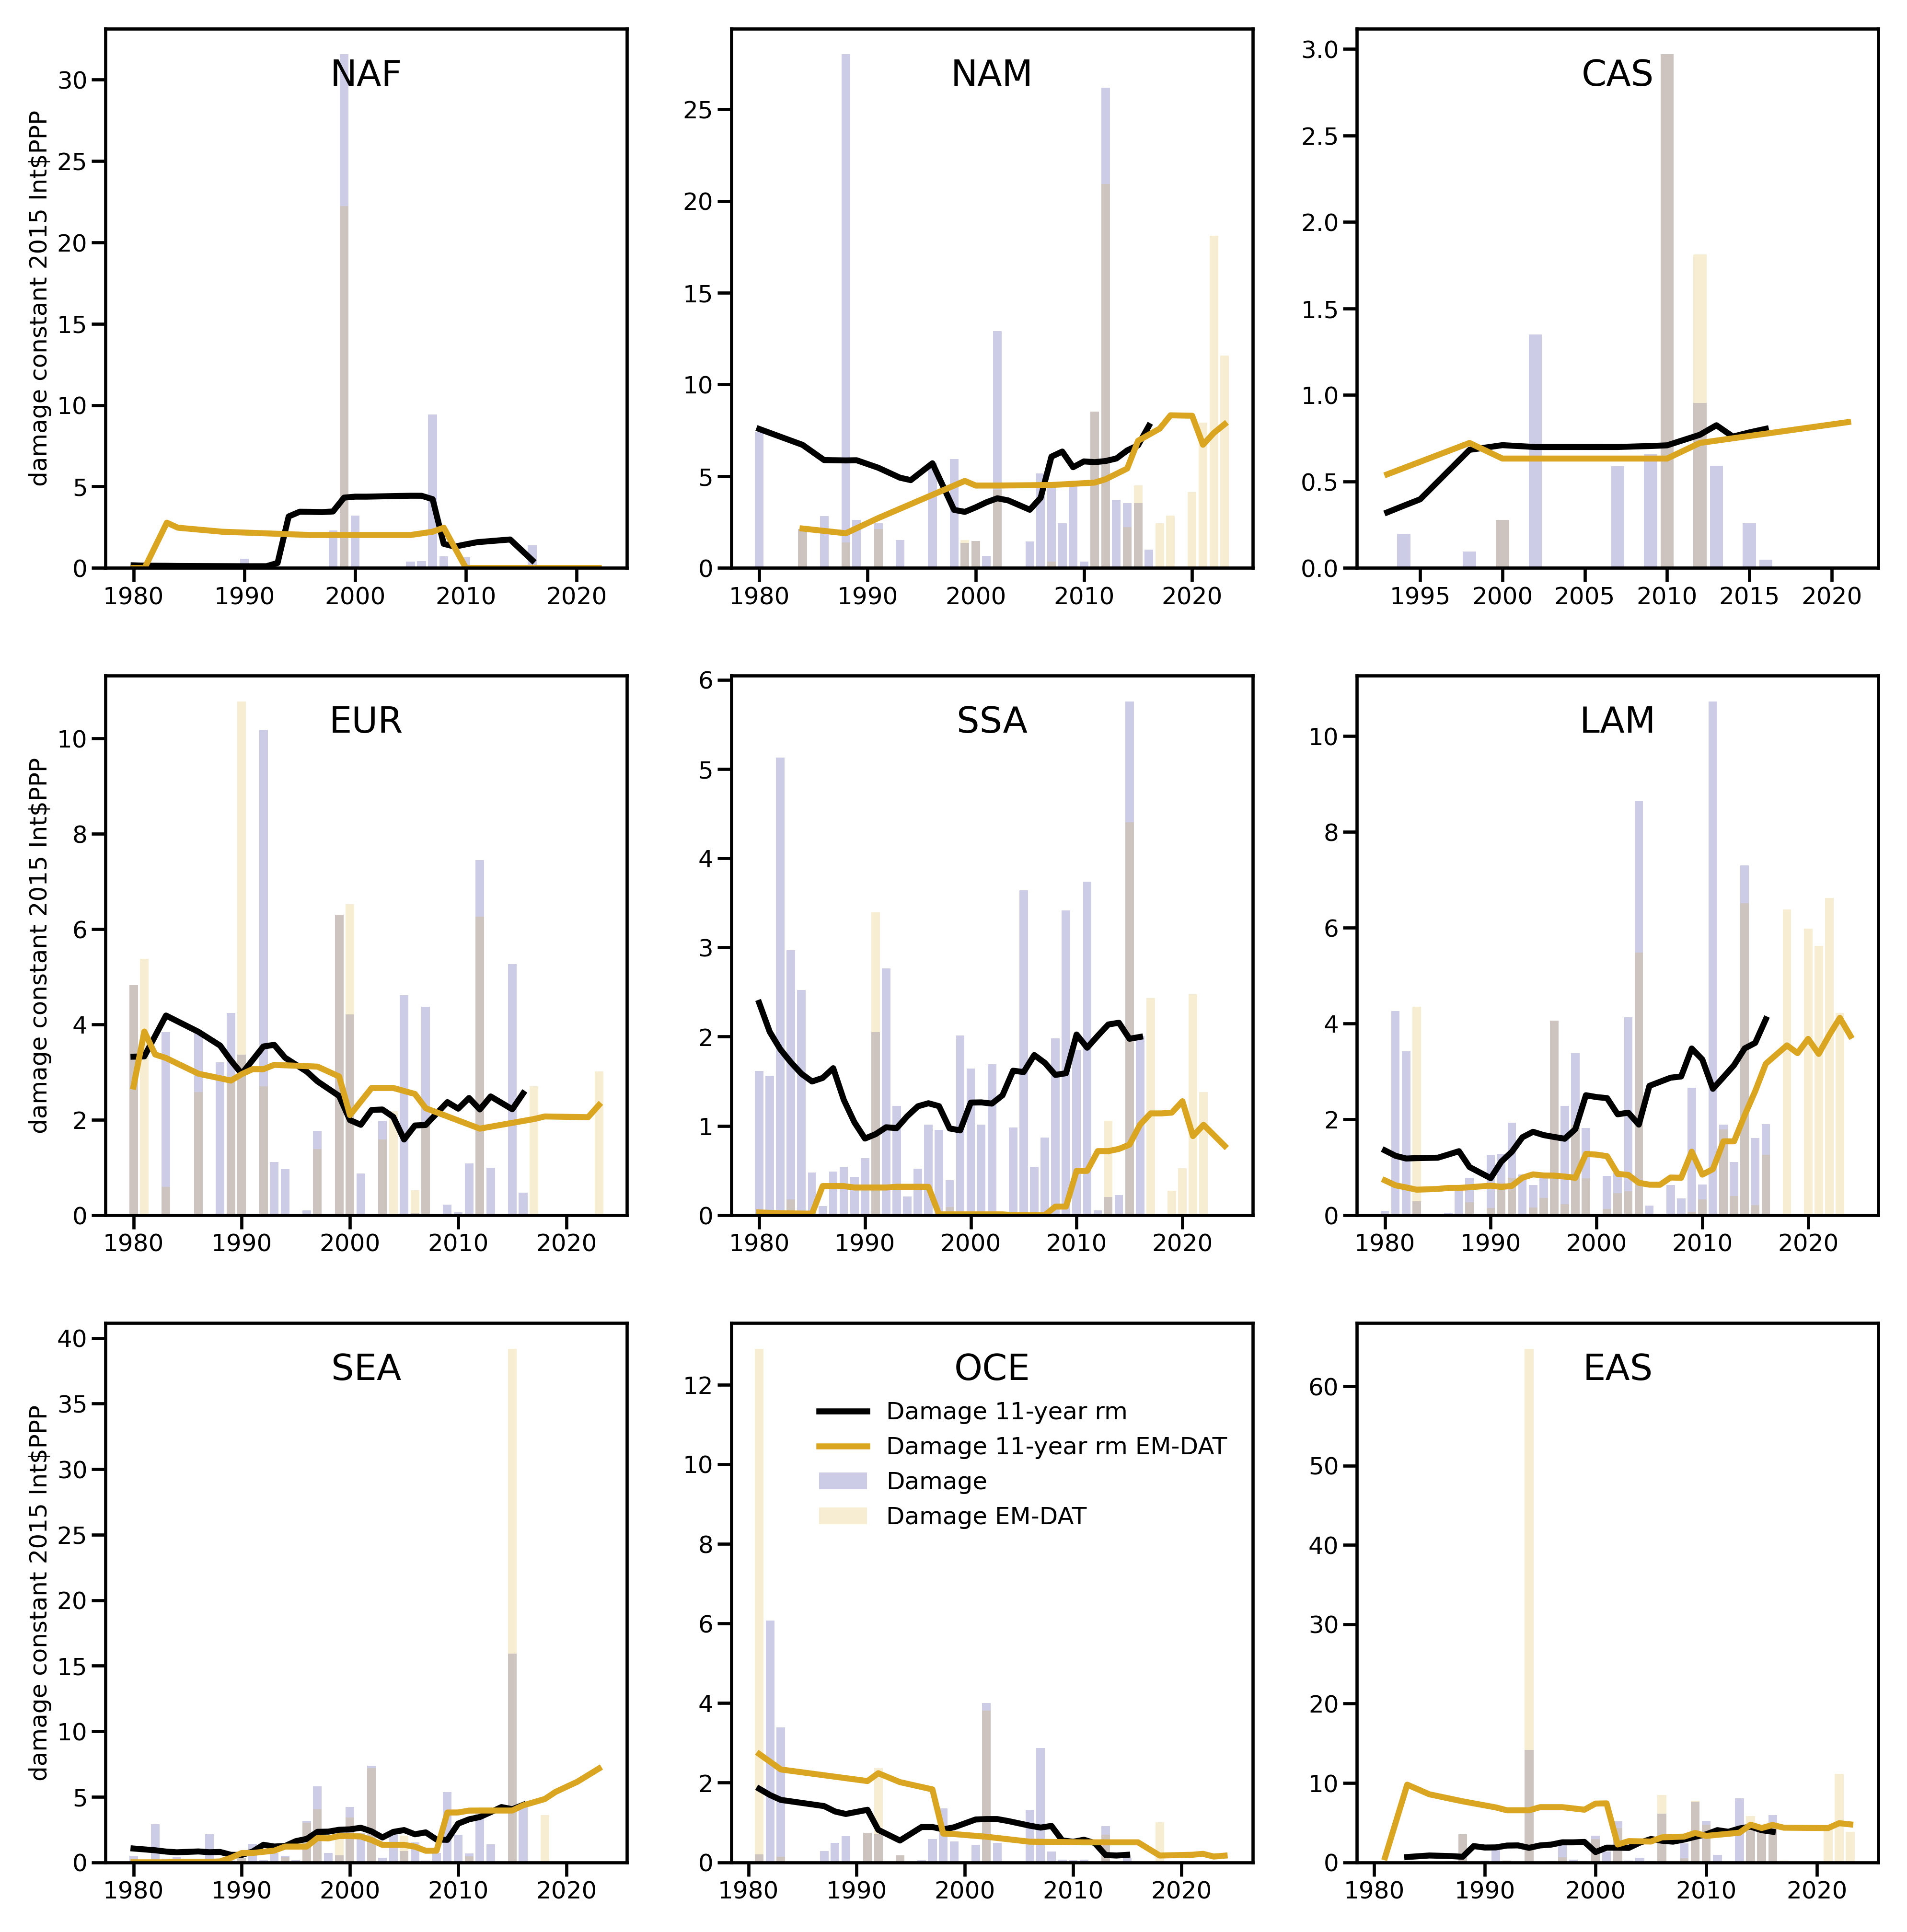

In [122]:
fig1 = plt.figure(figsize=(x_width,y_width), dpi=600)
plt.subplots_adjust(top=0.95, bottom= 0.05, left= 0.08, right=0.95, wspace=0.2, hspace=0.2)
gs = fig1.add_gridspec(3, 3)

r=0

for i,row in enumerate(np.arange(3)):
    for col in np.arange(3):
        f3_ax2 = fig1.add_subplot(gs[row:row+1,col:col+1])
        
        f3_ax2.set_title(regions[r], x=0.5,y=0.85, fontsize=9)
        f3_ax2.bar(agg_reg_year.loc[regions[r]].index, agg_reg_year.loc[regions[r],'damage_constant2015USD_PPP']/1e3,
                   color='darkblue', alpha=0.2, label='Damage')
        f3_ax2.plot(agg_reg_year.loc[regions[r]].index,
                    agg_reg_year.loc[regions[r],'damage_constant2015USD_PPP'].rolling(11, center=True,min_periods=5).mean()/1e3,
            label='Damage 11-year rm', color='k')

        f3_ax2.bar(agg_reg_year_emdat.loc[regions[r]].index, agg_reg_year_emdat.loc[regions[r],'damage_constant2015USD_PPP']/1e6,
                   color='goldenrod', alpha=0.2, label='Damage EM-DAT')
        f3_ax2.plot(agg_reg_year_emdat.loc[regions[r]].index,
                    agg_reg_year_emdat.loc[regions[r],'damage_constant2015USD_PPP'].rolling(11, center=True,min_periods=5).mean()/1e6,
            label='Damage 11-year rm EM-DAT', color='goldenrod')

        if col==0:
            f3_ax2.set_ylabel('damage constant 2015 Int$PPP', fontsize=6, labelpad=1.3)
                    
        f3_ax2.tick_params(axis='both',labelsize=6, pad=1.)
        
        if (col==1) & (row==2):
            f3_ax2.legend(fontsize=6, loc=(0.15,0.6), frameon=False)

        r+=1

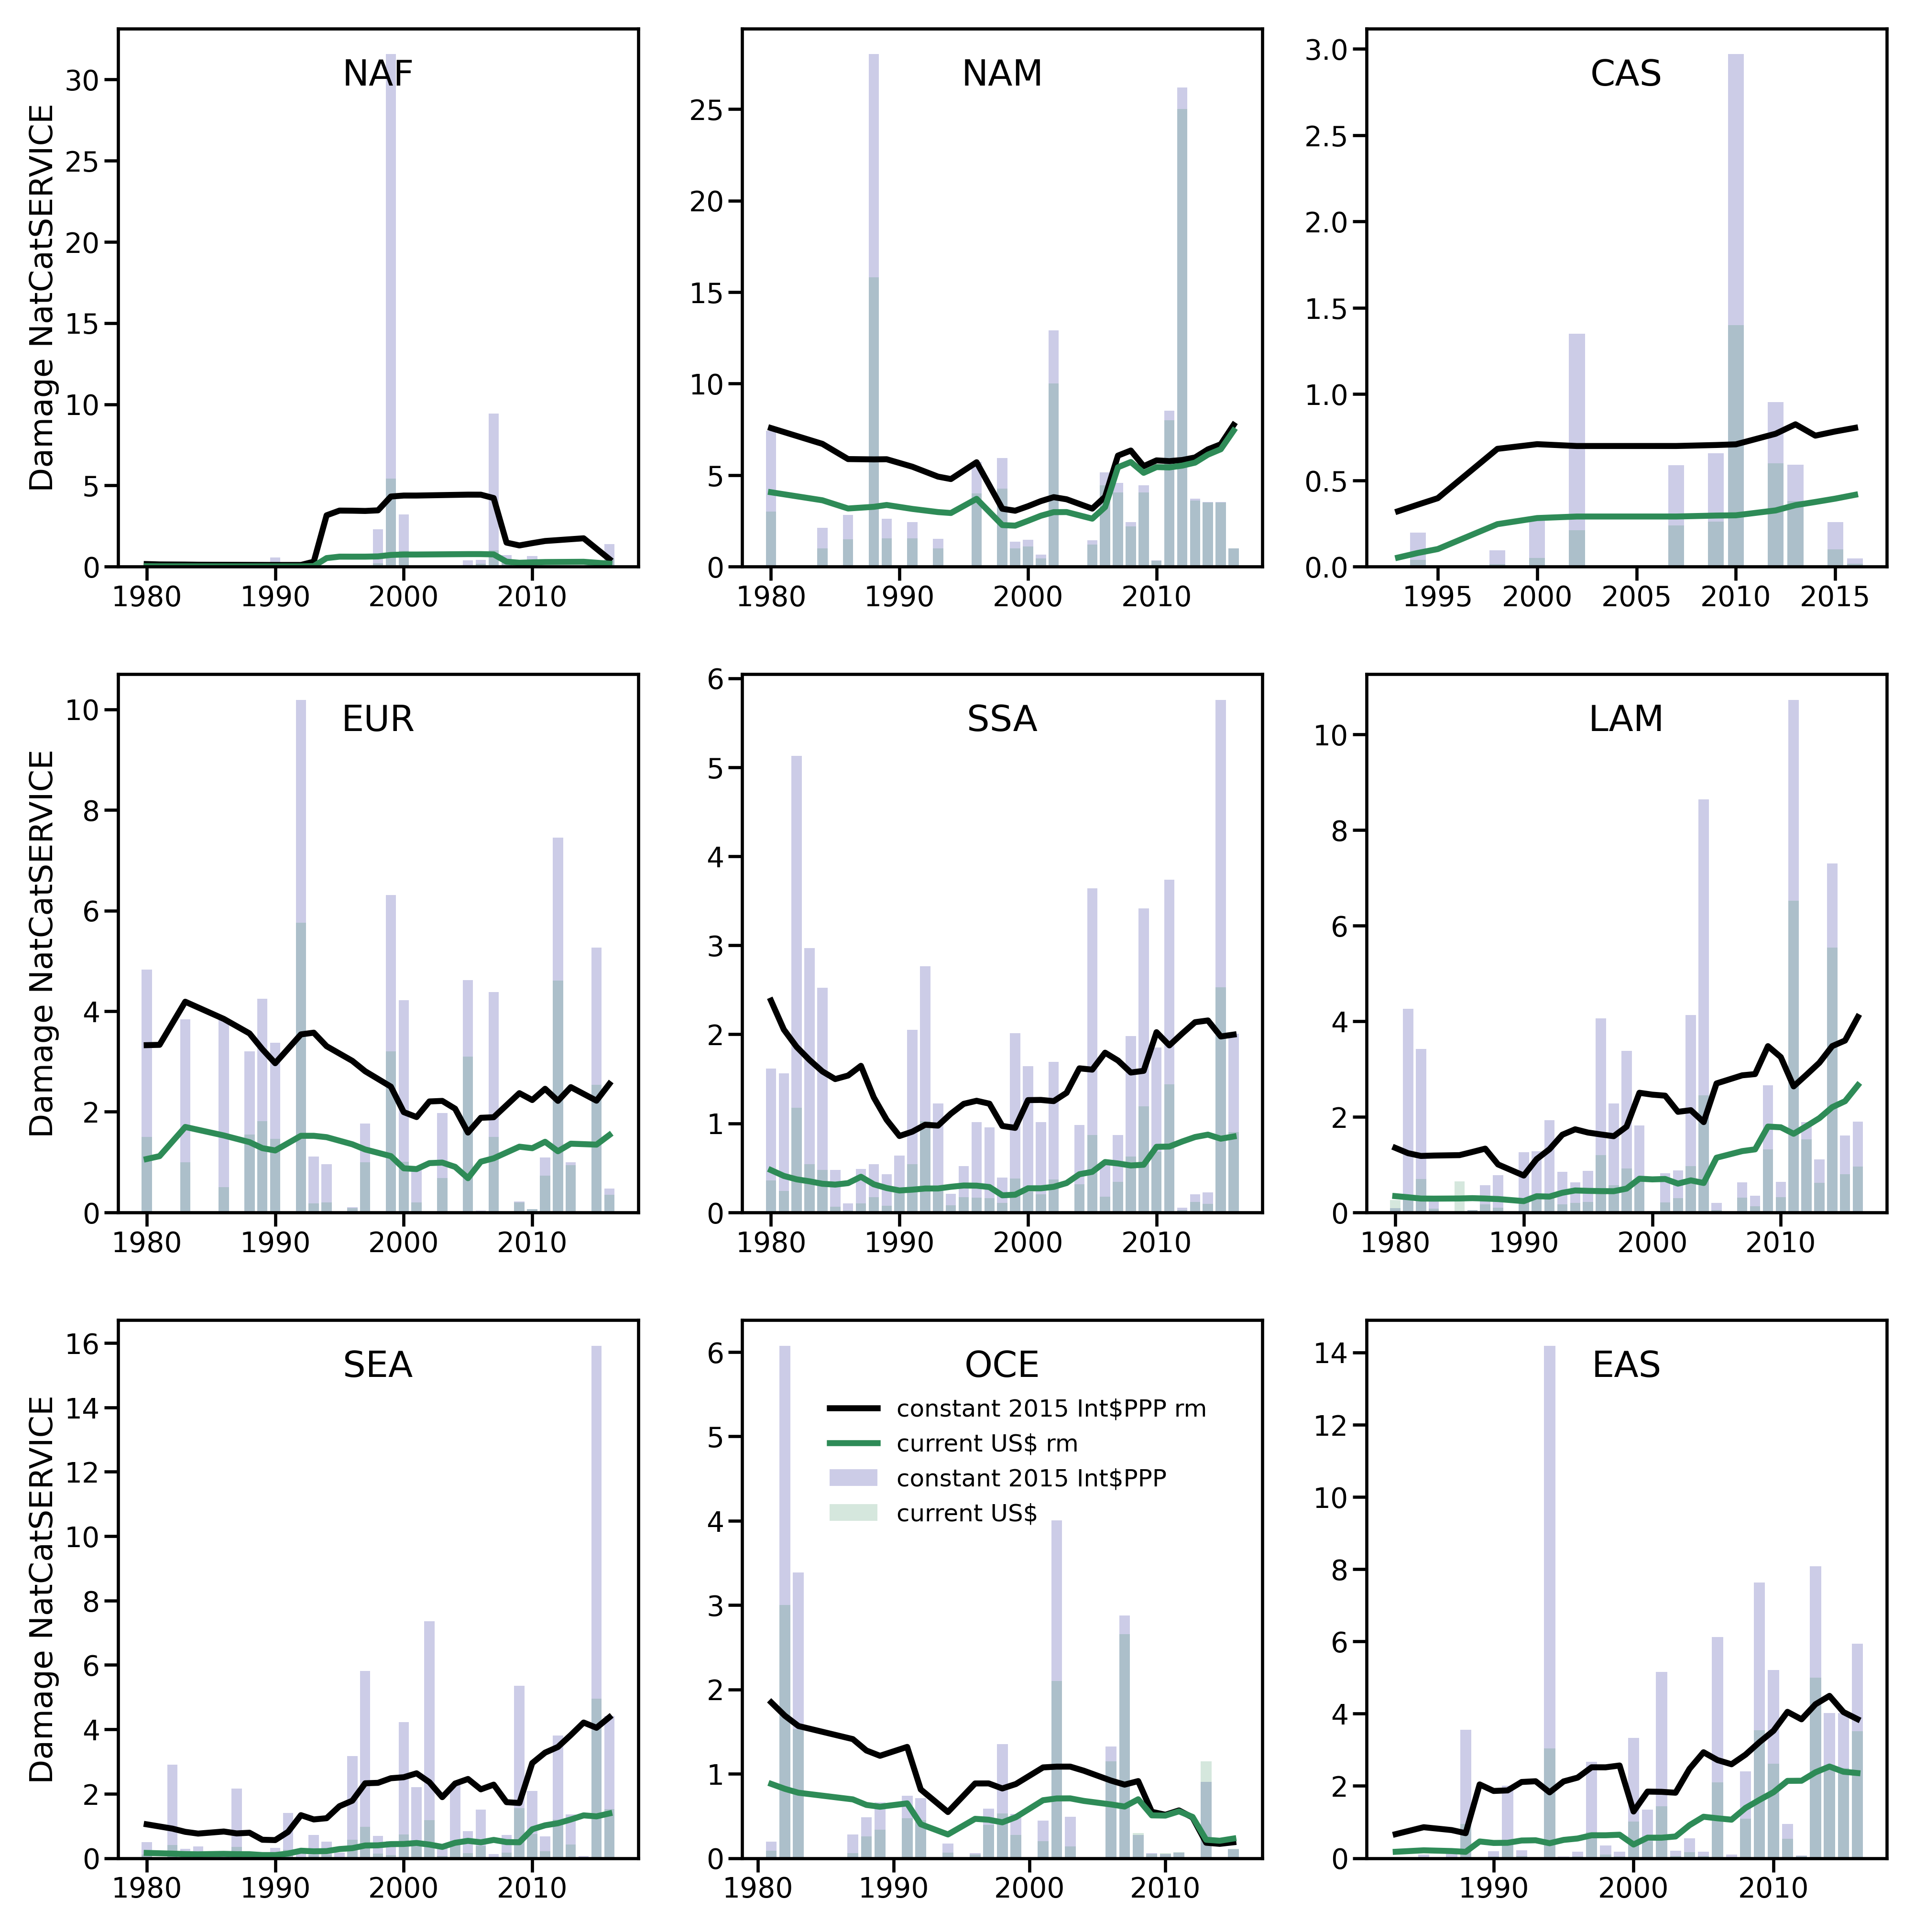

In [131]:
fig1 = plt.figure(figsize=(x_width,y_width), dpi=600)
plt.subplots_adjust(top=0.95, bottom= 0.05, left= 0.08, right=0.95, wspace=0.2, hspace=0.2)
gs = fig1.add_gridspec(3, 3)

r=0

for i,row in enumerate(np.arange(3)):
    for col in np.arange(3):
        f3_ax2 = fig1.add_subplot(gs[row:row+1,col:col+1])
        
        f3_ax2.set_title(regions[r], x=0.5,y=0.85, fontsize=9)
        f3_ax2.bar(agg_reg_year.loc[regions[r]].index, agg_reg_year.loc[regions[r],'damage_constant2015USD_PPP']/1e3,
                   color='darkblue', alpha=0.2, label='constant 2015 Int$PPP')
        f3_ax2.plot(agg_reg_year.loc[regions[r]].index,
                    agg_reg_year.loc[regions[r],'damage_constant2015USD_PPP'].rolling(11, center=True,min_periods=5).mean()/1e3,
            label='constant 2015 Int$PPP rm', color='k')

        f3_ax2.bar(agg_reg_year.loc[regions[r]].index, agg_reg_year.loc[regions[r],'damage_currentUSD_MER']/1e3,
                   color='seagreen', alpha=0.2, label='current US$')
        f3_ax2.plot(agg_reg_year.loc[regions[r]].index,
                    agg_reg_year.loc[regions[r],'damage_currentUSD_MER'].rolling(11, center=True,min_periods=5).mean()/1e3,
            label='current US$ rm', color='seagreen')

        if col==0:
            f3_ax2.set_ylabel('Damage NatCatSERVICE', fontsize=8, labelpad=1.3)
                    
        f3_ax2.tick_params(axis='both',labelsize=7, pad=1.)
        
        if (col==1) & (row==2):
            f3_ax2.legend(fontsize=6, loc=(0.15,0.6), frameon=False)

        r+=1

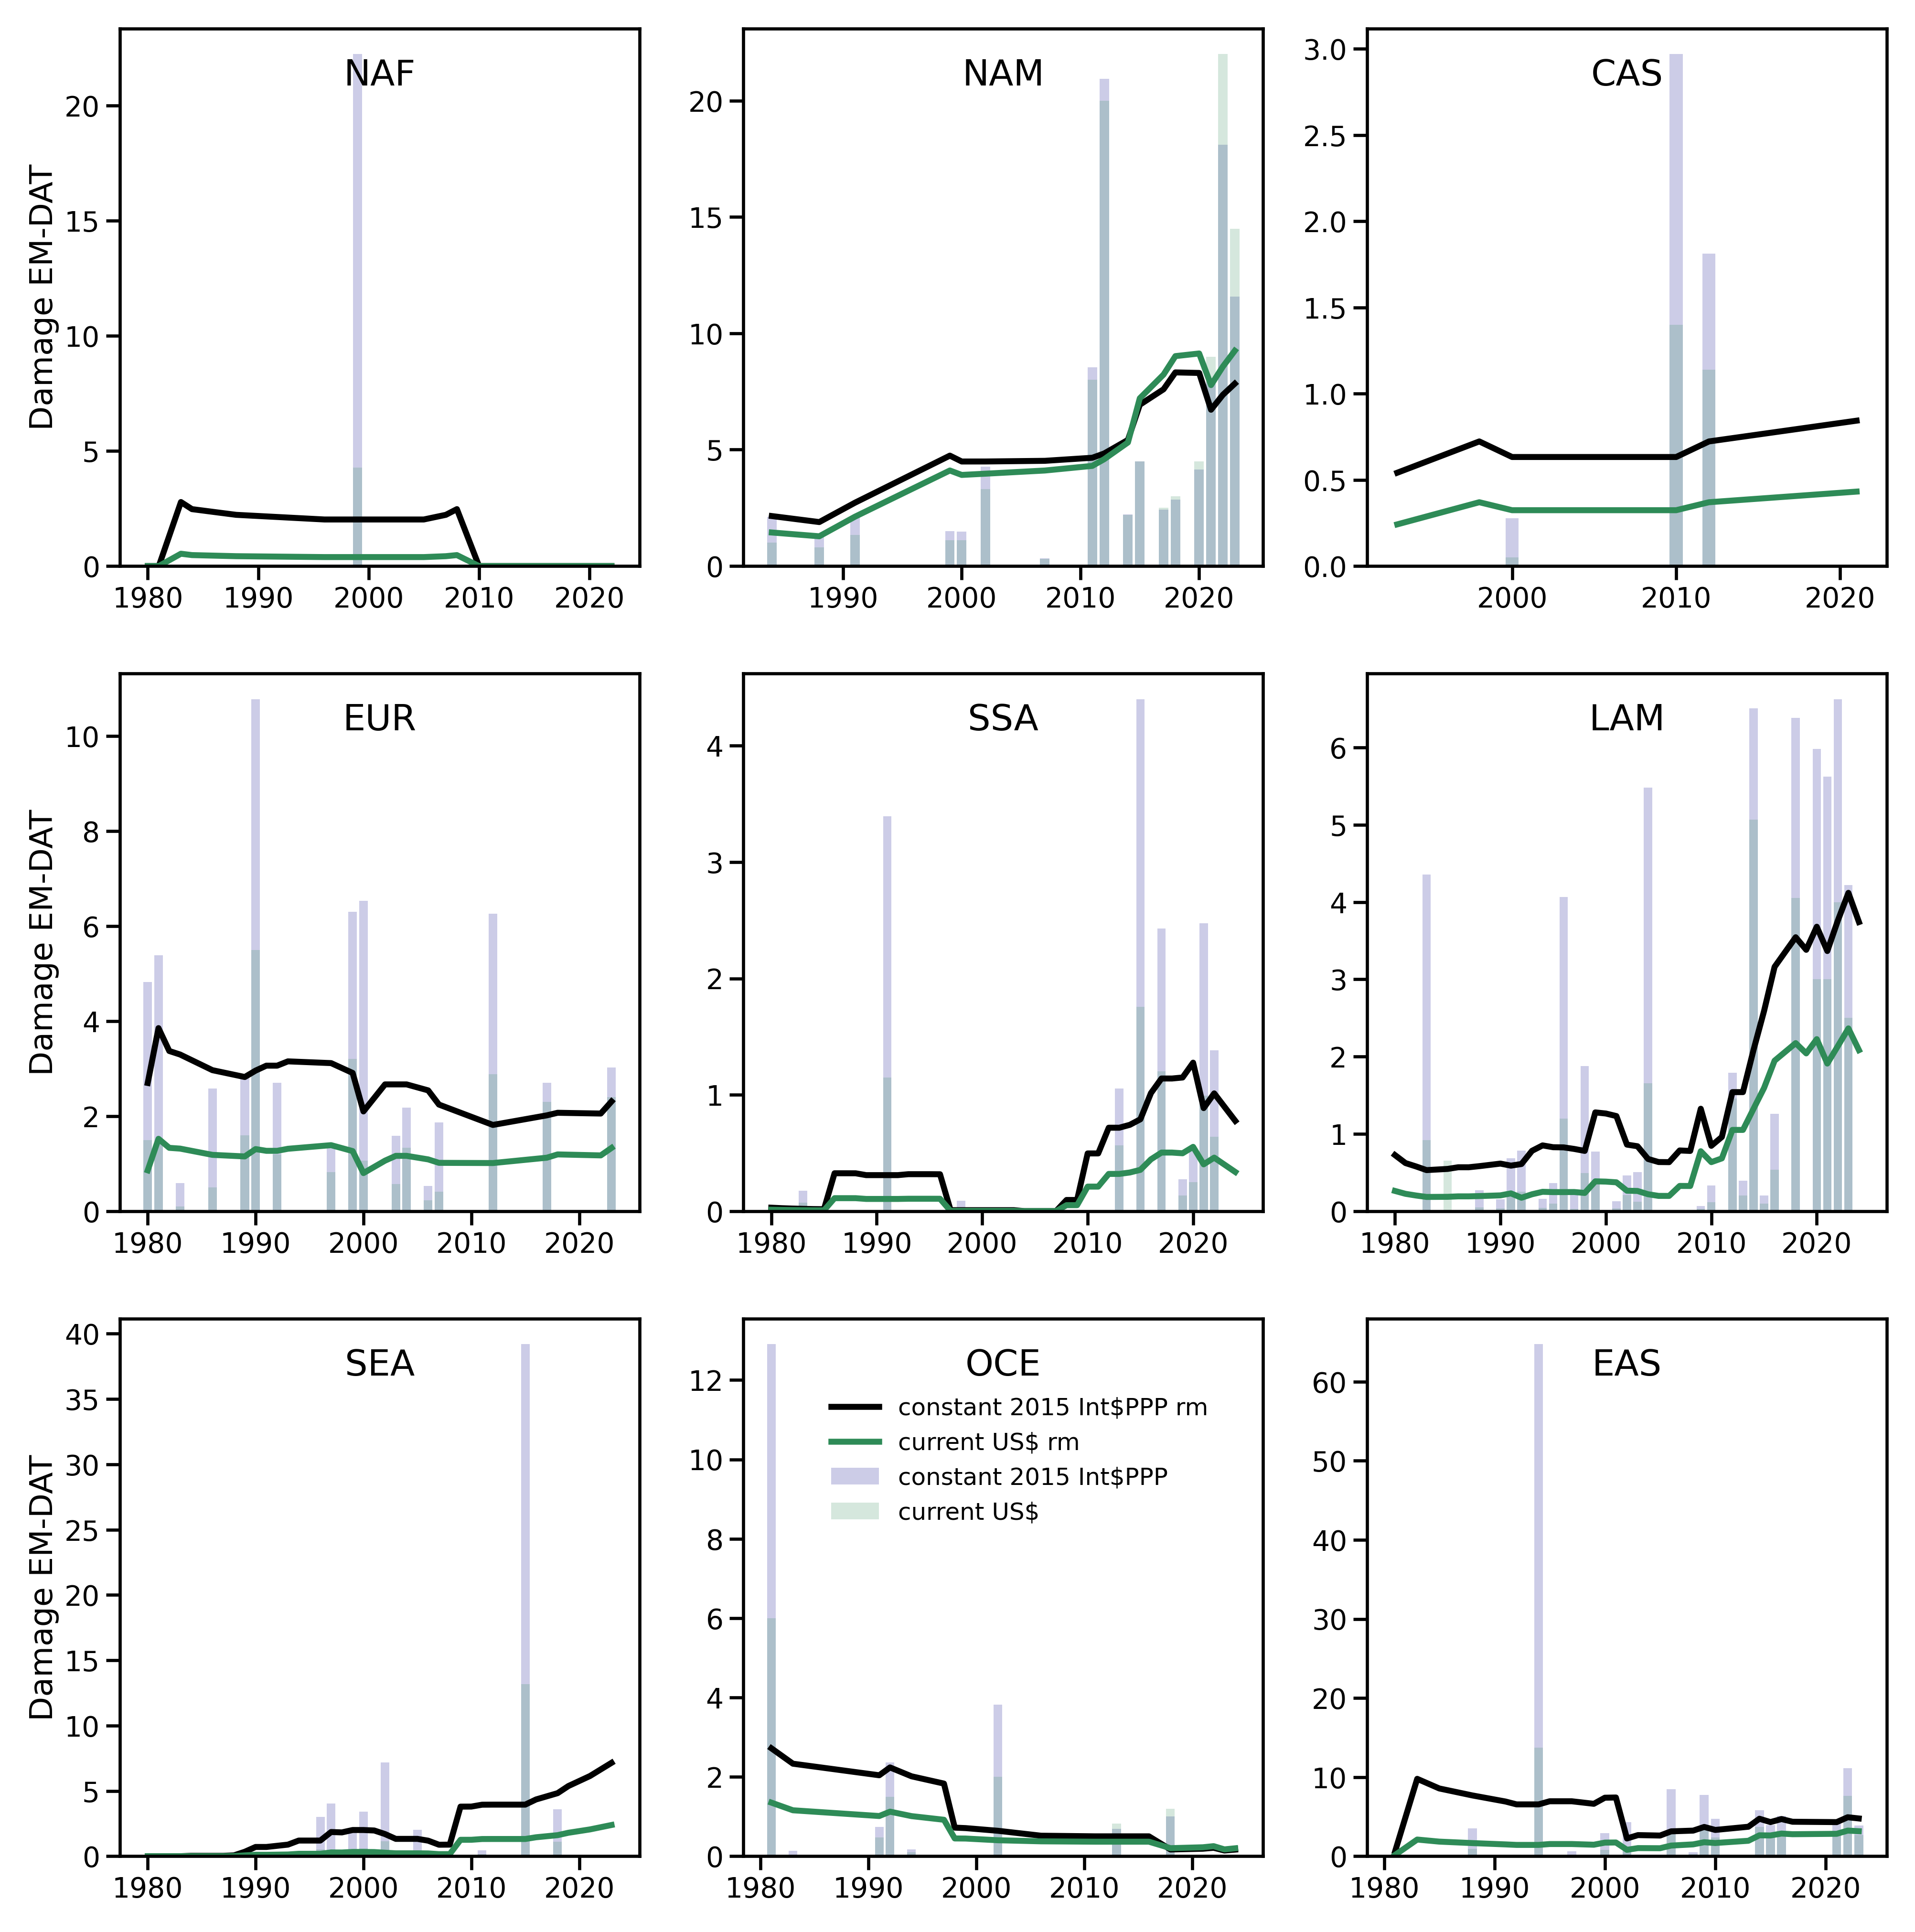

In [133]:
fig1 = plt.figure(figsize=(x_width,y_width), dpi=600)
plt.subplots_adjust(top=0.95, bottom= 0.05, left= 0.08, right=0.95, wspace=0.2, hspace=0.2)
gs = fig1.add_gridspec(3, 3)

r=0

for i,row in enumerate(np.arange(3)):
    for col in np.arange(3):
        f3_ax2 = fig1.add_subplot(gs[row:row+1,col:col+1])
        
        f3_ax2.set_title(regions[r], x=0.5,y=0.85, fontsize=9)
        f3_ax2.bar(agg_reg_year_emdat.loc[regions[r]].index, agg_reg_year_emdat.loc[regions[r],'damage_constant2015USD_PPP']/1e6,
                   color='darkblue', alpha=0.2, label='constant 2015 Int$PPP')
        f3_ax2.plot(agg_reg_year_emdat.loc[regions[r]].index,
                    agg_reg_year_emdat.loc[regions[r],'damage_constant2015USD_PPP'].rolling(11, center=True,min_periods=5).mean()/1e6,
            label='constant 2015 Int$PPP rm', color='k')

        f3_ax2.bar(agg_reg_year_emdat.loc[regions[r]].index, agg_reg_year_emdat.loc[regions[r],'damage_currentUSD_MER']/1e6,
                   color='seagreen', alpha=0.2, label='current US$')
        f3_ax2.plot(agg_reg_year_emdat.loc[regions[r]].index,
                    agg_reg_year_emdat.loc[regions[r],'damage_currentUSD_MER'].rolling(11, center=True,min_periods=5).mean()/1e6,
            label='current US$ rm', color='seagreen')

        if col==0:
            f3_ax2.set_ylabel('Damage EM-DAT', fontsize=8, labelpad=1.3)
                    
        f3_ax2.tick_params(axis='both',labelsize=7, pad=1.5)
        
        if (col==1) & (row==2):
            f3_ax2.legend(fontsize=6, loc=(0.15,0.6), frameon=False)

        r+=1